This code opens pmaps from files and uses ipywidgets to do some basic interpretation on the Daly River data set.

TODO in 2020 add interpretation tool

Neil Symington
neil.symington@ga.gov.au

In [1]:
#%matplotlib widget

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import aseg_gdf2
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.io import loadmat
from scipy import spatial
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import os
from scipy.spatial.ckdtree import cKDTree

In [3]:
def nearest_neighbours(points, coords, points_required = 1, max_distance = 250.):
    """

    :param points: array of points to find the nearest neighbour for
    :param coords: coordinates of points
    :param points_required: number of points to return
    :param max_distance: maximum search radius
    :return:
    """
    # Initialise tree instance
    kdtree = cKDTree(data=coords)

    # iterate throught the points and find the nearest neighbour
    distances, indices = kdtree.query(points, k=points_required,
                                      distance_upper_bound=max_distance)
    # Mask out infitnite distances in indices to avoid confusion
    mask = ~np.isfinite(distances)

    distances[mask] = np.nan

    return distances, indices

In [4]:
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\HowardE_WB_MGA52.nc"

lci_dat = netCDF4.Dataset(infile)

lci_coords = np.column_stack((lci_dat['easting'][:],
                          lci_dat['northing'][:]))

# Initialise tree instance for nearest neighbour searches
kdtree = cKDTree(data=lci_coords)

In [5]:
# bring in the rjmcmc data

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\garjmcmc\combined\HE_rjmcmc_.nc"

# Read in the data and convert to geodataframe

rj_dat = netCDF4.Dataset(infile)

In [6]:
# Now we bring in the magnetics to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\Magnetics\HE\HE_TMA_rtp_1VD.tif"

dataset = rasterio.open(inRaster)

mag = dataset.read(1)

mag[mag == dataset.get_nodatavals()] = np.nan


In [81]:
inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\G3D_interpretation\HE\top_cond.grd"

dataset = rasterio.open(inRaster)

topcond = dataset.read(1)


In [7]:
# Bring in a suset of the points to sample

infile = r"C:\Temp\HE_sel.csv"

df = pd.read_csv(infile)

df['top_conductor'] = np.nan

In [8]:
# Create a generator to iterate through the pandas dataframe

def gen(df):
    for index, row in df.iterrows():
        yield index, row
        
cond_gen = gen(df)

In [9]:

def onclick(event):
    if event.xdata != None and event.ydata != None:
        df.at[ind, 'top_conductor'] = event.ydata



In [12]:
def extract_data():
    
    freq = rj_dat['conducitivty_bin_count'][point_ind_rj].data.astype(np.float)

    cond_pdf = freq / freq.sum(axis =1)[0]

    cond_pdf[cond_pdf == 0] = np.nan
    
    cp_freq = rj_dat['change_point'][point_ind_rj].data.astype(np.float)
    
    cp_pdf = cp_freq / freq.sum(axis =1)[0]
    
    laybins = rj_dat['nlayer_bin_count'][point_ind_rj].data
    
    lay_prob = laybins / freq.sum(axis =1)[0]
    
    cond_cells = rj_dat["conductivity_cells"][:].data
    
    depth_cells = rj_dat['layer_top_depth'][point_ind_rj].data
    
    extent = [cond_cells.min(), cond_cells.max(), depth_cells.max(), depth_cells.min()]
    
    mean = rj_dat['conductivity_mean'][point_ind_rj].data
    p10 = rj_dat['conductivity_p10'][point_ind_rj].data
    p50 = rj_dat['conductivity_p50'][point_ind_rj].data
    p90 = rj_dat['conductivity_p90'][point_ind_rj].data
    
    lci_cond = lci_dat['conductivity'][point_ind_lci].data
    lci_depth_top = lci_dat['layer_top_depth'][point_ind_lci].data
    lci_doi = lci_dat['depth_of_investigation'][point_ind_lci].data
    
    misfit = rj_dat['misfit'][point_ind_rj].data
    sample_no = rj_dat['rj_sample_number'][:].data
    
    burnin = rj_dat["nburnin"][point_ind_rj].data
    nsamples = rj_dat['nsamples'][point_ind_rj].data
    nchains = rj_dat['nchains'][point_ind_rj].data
    
    return {'conductivity_pdf': cond_pdf, "change_point_pdf": cp_pdf, "conductivity_extent": extent,
           'cond_p10': p10, 'cond_p50': p50, 'cond_p90': p90, 'cond_mean': mean, 'depth_cells': depth_cells,
           'nlayer_bins': laybins, 'nlayer_prob': lay_prob, 'nsamples': nsamples, 'ndata': rj_dat['n_data'][:].data,
           "nchains": nchains, 'burnin': burnin, 'misfit': misfit, 'sample_no': sample_no, 'cond_cells': cond_cells, 'lci_cond': lci_cond,
           'lci_depth_top': lci_depth_top, 'lci_doi': lci_doi}
    
def HE_plot(D, outfile = None):
    fig = plt.figure(figsize = (12,10))

    # These are for interactive widget mode
    #fig.canvas.layout.width = '12in'
    #fig.canvas.layout.height= '8in'

    ax1 = fig.add_axes([0.05, 0.2, 0.35, 0.7])
    ax2 = fig.add_axes([0.45, 0.2, 0.2, 0.7])
    ax3 = fig.add_axes([0.72, 0.2, 0.2, 0.35])
    ax4 = fig.add_axes([0.72, 0.6, 0.2, 0.3])
    cbar_ax = fig.add_axes([0.05, 0.1, 0.35, 0.02])


    # Plot probability map
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('log10 conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1])
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])
    ax1.legend()

    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])
    ax2.legend()
    ax2.grid(which = 'both')

    #ax3.bar(D['nlayer_bins'], height = D['nlayer_prob'])
    #ax3.set_xlabel ("no of layers")
    ax3.imshow(mag, extent = [dataset.bounds[0], dataset.bounds[2],
                              dataset.bounds[1], dataset.bounds[3]],
              cmap= 'Greys', vmin = -5., vmax = 5.)
    ax3.plot(D['easting'],D['northing'], 'ro')
    # Ax3 will be our location
    sample = D['sample_no'][:]
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")

    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    if outfile is not None:
        indir = r"C:\Temp"
        fname = os.path.join(indir, str(D['fid']) + "_" + str(D['line']) + '.png')
    else:
        fname =  outfile
    
    return fig   

C:\Users\PCUser\Anaconda3\envs\garjmcmctdem\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


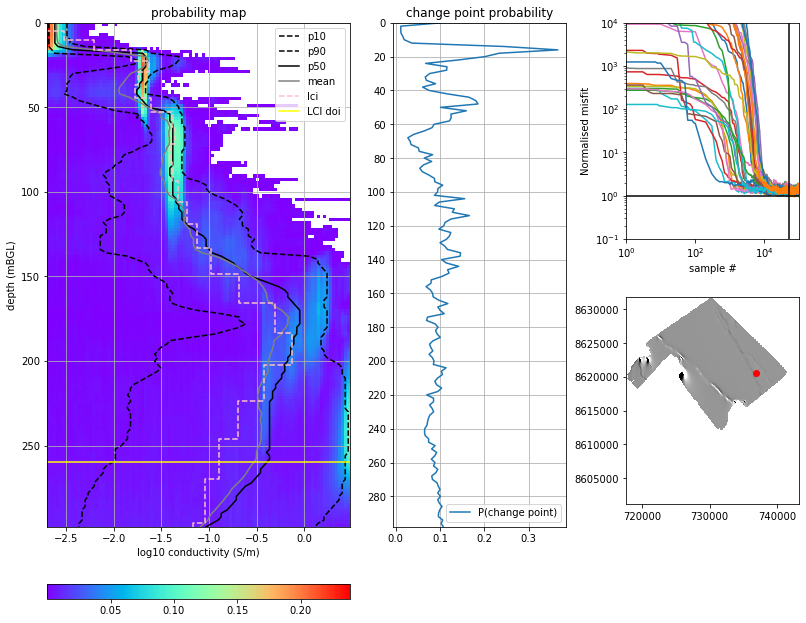

In [80]:
# Define some coordinates to investigate

ind, row = next(cond_gen)

point_ind_rj = np.where(rj_dat['fiducial'][:] == row['fiducial'])[0][0]

# Get the nearest lci point

easting, northing = row['easting'], row['northing']

# iterate throught the points and find the nearest neighbour
distance, point_ind_lci = kdtree.query([easting, northing], k=1,
                                  distance_upper_bound=200)

D = extract_data()

D['easting'], D['northing'] = easting, northing

fig = HE_plot(D)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [79]:
ind

65